# Meal Recommendation System

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

# Load the Dataset

In [23]:
# Load the dataset
df = pd.read_csv('recipe_final (1).csv')

df.head()

,Unnamed: 0,recipe_id,recipe_name,aver_rate,image_url,review_nums,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,ingredients_list
0,0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,15,36,1,42,21,81,2,"['pork belly', 'smoked paprika', 'kosher salt'..."
1,1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,19,18,10,73,33,104,41,"['sauerkraut drained', 'Granny Smith apples sl..."
2,2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,17,36,2,48,24,31,4,"['chicken wings', 'sprigs rosemary', 'head gar..."
3,3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,32,45,20,65,20,43,18,"['focaccia bread quartered', 'prepared basil p..."
4,4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,8,12,5,14,7,8,3,"['red potatoes', 'strips bacon', 'Sauce:', 'he..."


# Data Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48735 entries, 0 to 48734
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        48735 non-null  int64  
 1   recipe_id         48735 non-null  int64  
 2   recipe_name       48735 non-null  object 
 3   aver_rate         48735 non-null  float64
 4   image_url         48735 non-null  object 
 5   review_nums       48735 non-null  int64  
 6   calories          48735 non-null  int64  
 7   fat               48735 non-null  int64  
 8   carbohydrates     48735 non-null  int64  
 9   protein           48735 non-null  int64  
 10  cholesterol       48735 non-null  int64  
 11  sodium            48735 non-null  int64  
 12  fiber             48735 non-null  int64  
 13  ingredients_list  48735 non-null  object 
dtypes: float64(1), int64(10), object(3)
memory usage: 5.2+ MB


In [21]:
# Checks if there are missing values
df.isna().sum()

Unnamed: 0          0
recipe_id           0
recipe_name         0
aver_rate           0
image_url           0
review_nums         0
calories            0
fat                 0
carbohydrates       0
protein             0
cholesterol         0
sodium              0
fiber               0
ingredients_list    0
dtype: int64

In [3]:
# Check if there are duplicate rows
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [5]:
# numerical columns
num_cols = df[['calories', 'fat', 'carbohydrates', 'protein', 'cholesterol', 'sodium', 'fiber']]

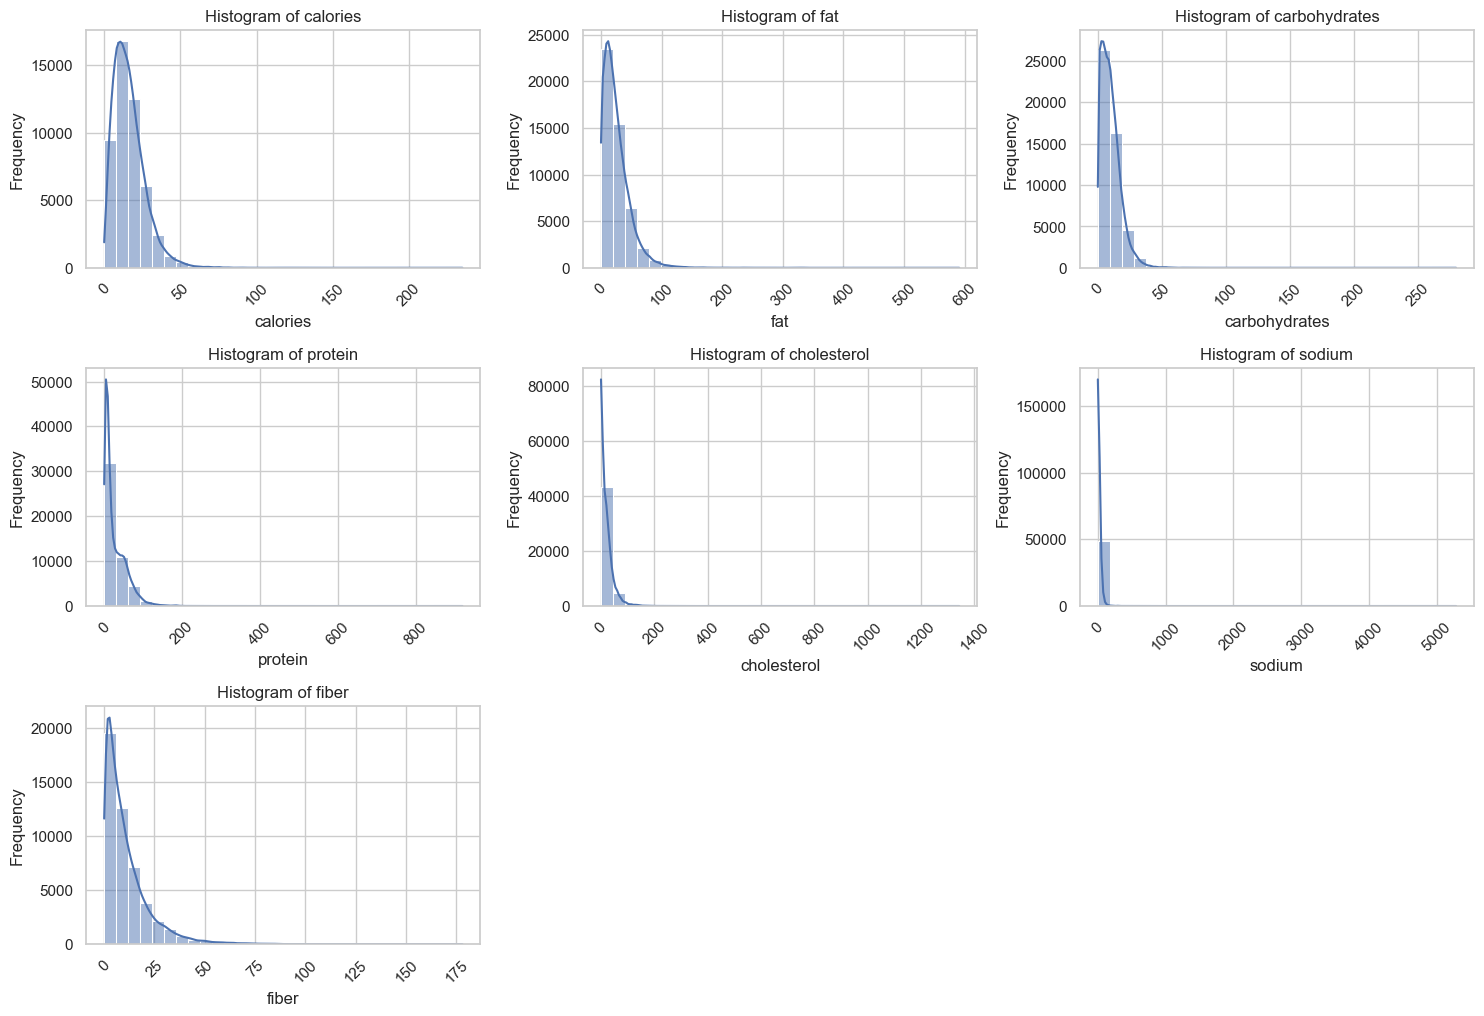

In [4]:
# Visualize Numerical Features
sns.set(style="whitegrid")

plt.figure(figsize=(15, 30))
for i, col in enumerate(num_cols, 1):
    plt.subplot(9, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

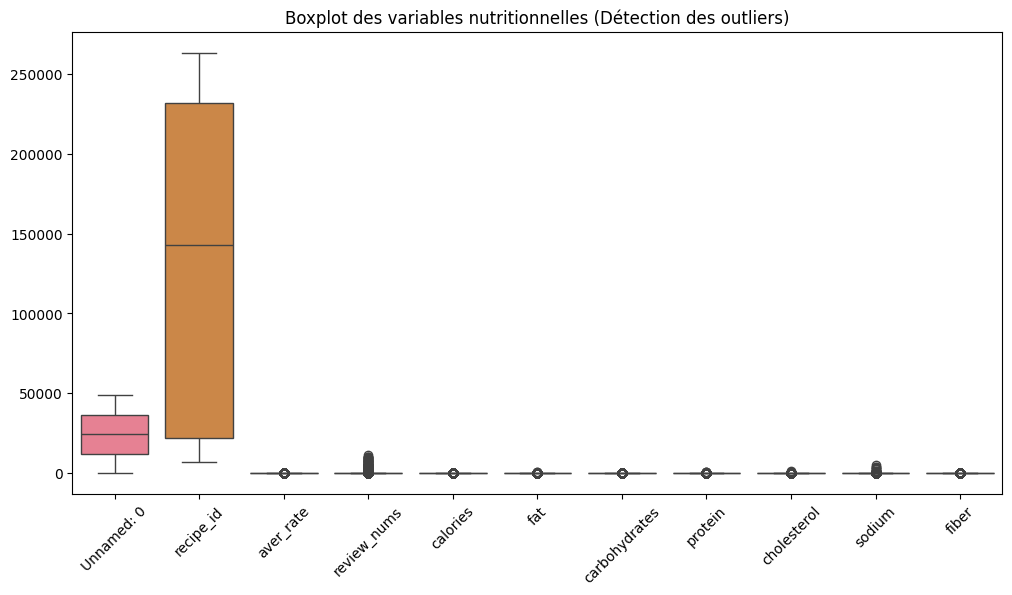

In [16]:
# visualiser les outliers
numeric_columns = df.select_dtypes(include=['number']).columns  # Ne garde que les colonnes numériques

# Tracer un boxplot propre
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_columns].dropna())  # Enlever les lignes avec NaN
plt.xticks(rotation=45)
plt.title("Boxplot des variables nutritionnelles (Détection des outliers)")
plt.show()

In [17]:
# Preprocess Ingredients
vectorizer = TfidfVectorizer()
X_ingredients = vectorizer.fit_transform(df['ingredients_list'])

In [18]:
# Normalize Numerical Features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[['calories', 'fat', 'carbohydrates', 'protein', 'cholesterol', 'sodium', 'fiber']])

In [19]:
# Combine Features
X_combined = np.hstack([X_numerical, X_ingredients.toarray()])

In [ ]:
# la validation croisée pour tester différentes valeurs de k pour choisir le meilleure k
# Liste des valeurs de k à tester
k_values = range(1, 11) 
scores = []

# Cross-validation avec ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_combined, df.index, cv=cv, scoring='accuracy').mean()
    scores.append(score)

# Tracer les résultats
plt.plot(k_values, scores, marker='o', linestyle='dashed')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Score de validation croisée")
plt.title("Impact du choix de k sur la performance")
plt.show()

# Meilleur k
best_k = k_values[np.argmax(scores)]
print(f"Meilleur k : {best_k}")

# Machine Learning Model

In [25]:
# Train KNN Model
knn = NearestNeighbors(n_neighbors=3, metric='euclidean')
knn.fit(X_combined)

NearestNeighbors(metric='euclidean', n_neighbors=3)

# Recommendation Faction

In [26]:
# Function to Recommend Recipes
def recommend_recipes(input_features):
    input_features_scaled = scaler.transform([input_features[:7]])
    input_ingredients_transformed = vectorizer.transform([input_features[7]])
    input_combined = np.hstack([input_features_scaled, input_ingredients_transformed.toarray()])
    distances, indices = knn.kneighbors(input_combined)
    recommendations = df.iloc[indices[0]]
    return recommendations[['recipe_name', 'ingredients_list', 'image_url']]

# Example Input
input_features = [15, 36, 1, 42, 21, 81, 2, 'pork belly, smoked paprika, kosher salt']
recommendations = recommend_recipes(input_features)
recommendations

C:\Users\bouka\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,recipe_name,ingredients_list,image_url
0,Homemade Bacon,"['pork belly', 'smoked paprika', 'kosher salt'...",https://images.media-allrecipes.com/userphotos...
3507,Char Siu (Chinese Barbeque Pork),"['honey', 'Shaoxing cooking wine', 'hoisin sau...",https://images.media-allrecipes.com/userphotos...
1926,Adobo Twist,"['vegetable oil', 'onion', 'head garlic', 'por...",https://images.media-allrecipes.com/userphotos...
